In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
import healpy as hp
import pysm 
from pysm.nominal import models
from pysm.common import convert_units

In [2]:
dust = hp.read_map('/smc/jianyao/Ali_maps/ffp10_newdust_total_353_full_map.fits', field = None, h = True)

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


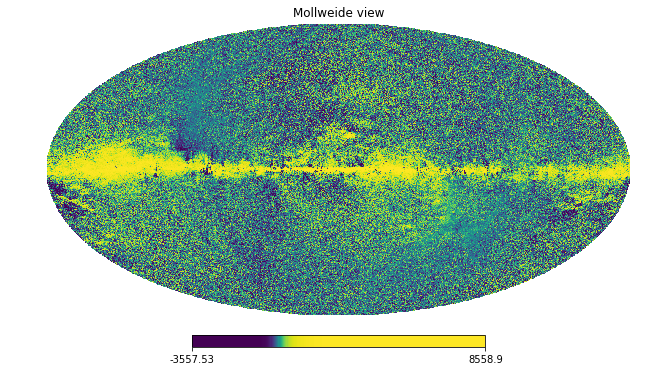

In [8]:
hp.mollview(dust[0][1]*1e6, norm = 'hist')

In [51]:
nu = np.array([95, 150, 353]);nside = 512;
coefficients = convert_units("uK_RJ", "uK_CMB", nu)

def convert_unit(map):
    Nf = len(nu)
    for i in range(0,Nf):
        map[i] = map[i]*coefficients[i]
    return map

sky_config = {'dust':models('d0', nside)}
sky = pysm.Sky(sky_config)

dust_pysm = (sky.signal()(nu))


In [56]:
dust_beta = np.ones(len(hp.read_map('/home/jianyao/PySM_public/pysm/template/dust_t_new.fits')))*1.54
#hp.read_map('/home/jianyao/PySM_public/pysm/template/dust_beta.fits', field= None)

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [64]:
(95.0/353)**1.54

0.13247114980134148

In [57]:
dust_extra = np.zeros_like(dust_pysm[0])
# dust_extra Q map
dust_extra[1] = dust_q*(95.0/353)**(dust_beta)
#dust_extra U map 
dust_extra[2] = dust_u*(95.0/353)**(dust_beta)

In [62]:
dust_pysm[0][1]/dust_pysm[1][1]

array([0.53036479, 0.53036479, 0.53036479, ..., 0.53036479, 0.53036479,
       0.53036479])

In [58]:
dust_extra[1]

array([ 0.02511631, -0.03705801,  0.06678372, ..., -0.00311247,
        0.01099396, -0.01479959])

In [50]:
dust_q[-1]*(95.0/353)**(dust_beta[-1])

-0.01414528522034181

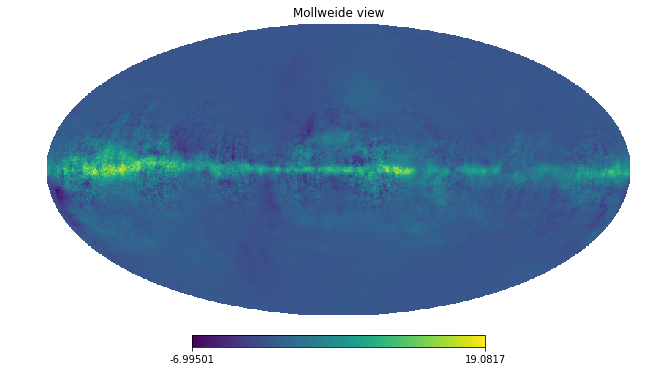

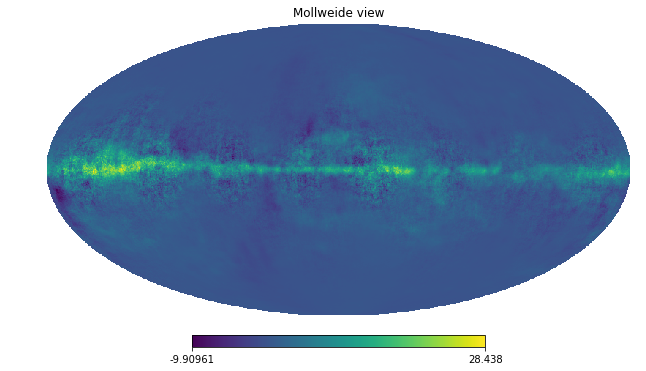

In [38]:
hp.mollview(dust_extra[1])
hp.mollview(dust_pysm[0][1])

In [35]:
dust_q = hp.read_map('/home/jianyao/PySM_public/pysm/template/dust_q_new.fits')
dust_u = hp.read_map('/home/jianyao/PySM_public/pysm/template/dust_u_new.fits')

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


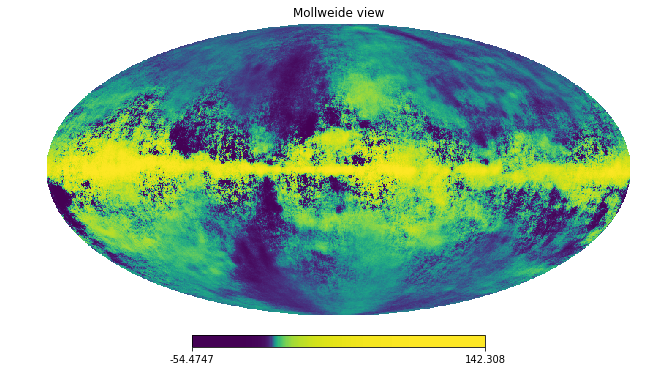

In [33]:
hp.mollview(dust_q[0], norm = 'hist')

In [65]:
dust_psm_95 = hp.read_map('/smc/jianyao/Ali_maps/thermaldust_map_95GHz.fits')
dust_psm_150 = hp.read_map('/smc/jianyao/Ali_maps/thermaldust_map_150GHz.fits')

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


Text(0.1, 0.8, 'dd')

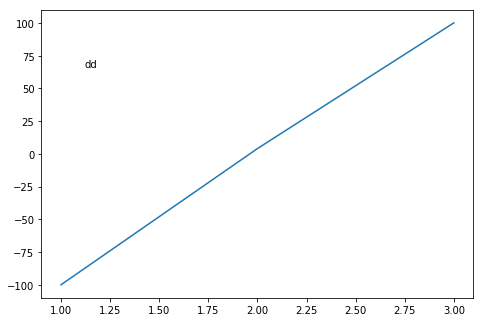

In [80]:
fig = plt.figure(1)
ax = fig.add_axes([0,0,1,1])
a = [1,2,3]
b = [-100,4,100]
plt.plot(a,b)
plt.text(0.1, 0.8, 'dd',transform=ax.transAxes)

ValueError: not enough values to unpack (expected 2, got 1)

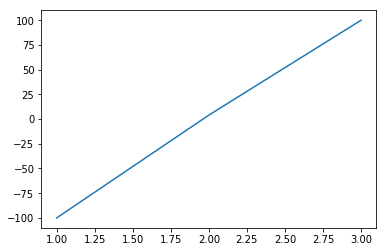

In [84]:
fig, ax = plt.plot(a, b)

matplotlib.axes._subplots.AxesSubplot

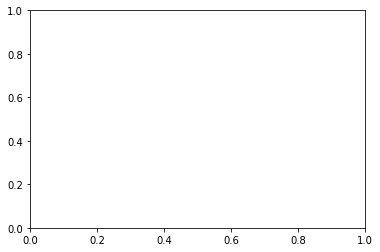

In [89]:
type(plt.subplots()[1])